In [1]:
!pip install transformers

In [2]:
!git lfs install

Git LFS initialized.


In [3]:
!git clone https://huggingface.co/bert-base-uncased

Cloning into 'bert-base-uncased'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 85 (delta 32), reused 82 (delta 31), pack-reused 0 (from 0)
Unpacking objects: 100% (85/85), 330.57 KiB | 4.86 MiB/s, done.
Filtering content: 100% (7/7), 3.21 GiB | 49.04 MiB/s, done.


In [4]:
!pip install scipy

In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
# pip install numpy==1.26

In [7]:
pip install scikit-learn==1.6.1

In [8]:
import pandas as pd
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import spacy

In [9]:
print(np.__version__)

1.26.0


In [10]:
dataset = pd.read_csv('UpdatedResumeDataSet.csv')

In [11]:
dataset.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9., ]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sentence in sentences:
        if any(criteria in sentence for criteria in ['skills', 'education']):
            words = word_tokenize(sentence)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features


In [14]:
def get_embeddings(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy()
    return embeddings

In [15]:
dataset["Cleaned_Features"] = dataset["Resume"].apply(preprocess_text)

In [16]:
dataset.head(10)

,Category,Resume,Cleaned_Features
0,Data Science,Skills * Programming Languages: Python (pandas...,{'feature': 'skills programming languages pyth...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,{'feature': 'education details may may b e uit...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",{'feature': 'areas interest deep learning cont...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,{'feature': 'skills r python sap hana tableau ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",{'feature': 'education details mca ymcaust far...
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",{'feature': 'skills c basics iot python matlab...
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,{'feature': 'skills python tableau data visual...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,{'feature': 'education details b tech rayat ba...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,{'feature': 'personal skills ability quickly g...
9,Data Science,Expertise â Data and Quantitative Analysis â...,{'feature': 'expertise data quantitative analy...


In [17]:
dataset.drop(columns=['Resume'], inplace=True)

In [18]:
dataset.head()

,Category,Cleaned_Features
0,Data Science,{'feature': 'skills programming languages pyth...
1,Data Science,{'feature': 'education details may may b e uit...
2,Data Science,{'feature': 'areas interest deep learning cont...
3,Data Science,{'feature': 'skills r python sap hana tableau ...
4,Data Science,{'feature': 'education details mca ymcaust far...


In [19]:
jobs_dict = {
    "job_titles":["Data Scientist", "Machine Learning Engineer", "Data Analyst", "Backend Developer", "AI Research Intern", "Cloud DevOps Engineer", "Frontend React Developer", "Software Engineer (Full Stack)", "Product Data Scientist", "AI Prompt Engineer"],
    "job_descriptions":["We're seeking a Data Scientist proficient in Python, machine learning, and statistical modeling. Responsibilities include building predictive models, analyzing large datasets, and presenting insights. Experience with Pandas, Scikit-learn, and SQL required. 2+ years of experience preferred.",
                        "Looking for an ML Engineer with deep knowledge of TensorFlow or PyTorch. You'll build, optimize, and deploy ML models in production. Required: Python, APIs, cloud platforms (AWS or GCP). Strong software engineering fundamentals are a plus.",
                        "Join our team as a Data Analyst to transform raw data into actionable insights. Skills in Excel, SQL, Tableau, and Python are important. Understanding of business metrics and good communication is key.",
                        "Hiring a backend developer experienced in Node.js, REST APIs, and PostgreSQL. You'll design robust APIs and integrate with microservices. Knowledge of Docker and CI/CD pipelines is a bonus.",
                        "Assist in NLP and computer vision research. Looking for students or recent grads with experience in PyTorch, Hugging Face, and academic writing. Strong math/ML foundations are essential.",
                        "Manage and automate cloud infrastructure using AWS, Terraform, and Jenkins. Must be proficient in shell scripting and monitoring tools like Prometheus or Grafana.",
                        "React developer needed to build interactive web apps. Must know JavaScript, React, Redux, and responsive design. Familiarity with Figma or design tools is a plus.",
                        "Build and maintain full-stack applications using Python (Django or Flask) and React. Database knowledge (PostgreSQL/MySQL) and Git workflows required.",
                        "Work cross-functionally to analyze user behavior and experiment with product features. Tools: SQL, Python, A/B testing platforms. Experience with product analytics (Mixpanel, Amplitude) is beneficial.",
                        "Design and test prompts for large language models like GPT-4. Should understand NLP tasks, LLM APIs, and prompt engineering best practices. Creative writing or UX experience is a bonus."]
}

In [20]:
dataset_jobs = pd.DataFrame(jobs_dict)

In [21]:
dataset_jobs['Features'] =dataset_jobs['job_descriptions'].apply(lambda x : preprocess_text(x)['feature'])

In [22]:
dataset_jobs.head()

,job_titles,job_descriptions,Features
0,Data Scientist,We're seeking a Data Scientist proficient in P...,
1,Machine Learning Engineer,Looking for an ML Engineer with deep knowledge...,
2,Data Analyst,Join our team as a Data Analyst to transform r...,join team data analyst transform raw data acti...
3,Backend Developer,Hiring a backend developer experienced in Node...,
4,AI Research Intern,Assist in NLP and computer vision research. Lo...,


In [23]:
dataset_jobs.to_csv('dataset_jobs.csv')

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [25]:
# job_desc_embeddings = np.array([get_embeddings(desc, model_name) for desc in dataset_jobs['job_descriptions']]).squeeze()
# resume_embeddings = np.array([get_embeddings(text, model_name) for text in dataset['Cleaned_Features']]).squeeze()

In [26]:
pairs = []

for i, resume in tqdm(enumerate(dataset['Cleaned_Features'])):
    for j, text in enumerate( dataset_jobs['job_descriptions']):
        resume_emb = np.array(get_embeddings(resume, model_name)).squeeze()
        text_emb = np.array(get_embeddings(text, model_name)).squeeze()
        similarity = cosine_similarity([text_emb], [resume_emb])
        print(round(similarity[0][0] * 100, 2))
        match_score = round(similarity[0][0] * 100, 2)  # Scale to 0–100%
        pairs.append((resume, text, match_score))

0it [00:00, ?it/s]

66.83
67.22
63.07
61.51
62.73
60.22
64.46
63.1


1it [00:01,  1.88s/it]

66.71
63.91
71.26
72.76
67.86
66.51
72.21
64.92
70.86
64.41


2it [00:03,  1.52s/it]

72.43
68.09
69.57
72.48
66.75
67.49
68.37
66.03
71.67
66.76


3it [00:04,  1.44s/it]

70.57
69.67
62.44
63.3
60.85
57.48
58.68
56.01
60.74
58.61


4it [00:06,  1.47s/it]

62.66
59.92
71.96
71.91
69.44
68.2
69.95
66.88
73.4
67.66


5it [00:07,  1.39s/it]

72.31
69.53
72.22
73.32
70.08
68.59
71.29
66.36
73.45
68.13


6it [00:08,  1.51s/it]

71.45
72.22
71.6
71.96
70.36
64.31
68.67
63.21
69.43
64.76


7it [00:10,  1.52s/it]

71.4
67.31
68.07
68.94
63.85
63.28
64.58
62.25
65.53
64.91


8it [00:12,  1.55s/it]

65.93
66.04
73.04
74.63
70.17
67.47
72.51
65.73
71.15
67.8


9it [00:13,  1.49s/it]

71.98
70.8
62.99
63.3
61.05
57.17
60.6
55.83
61.17
58.78


10it [00:15,  1.51s/it]

63.27
59.13
66.83
67.22
63.07
61.51
62.73
60.22
64.46
63.1


11it [00:16,  1.51s/it]

66.71
63.91
71.26
72.76
67.86
66.51
72.21
64.92
70.86
64.41


12it [00:17,  1.47s/it]

72.43
68.09
69.57
72.48
66.75
67.49
68.37
66.03
71.67
66.76


13it [00:19,  1.46s/it]

70.57
69.67
62.44
63.3
60.85
57.48
58.68
56.01
60.74
58.61
62.66


14it [00:21,  1.69s/it]

59.92
71.96
71.91
69.44
68.2
69.95
66.88
73.4
67.66
72.31


15it [00:22,  1.57s/it]

69.53
72.22
73.32
70.08
68.59
71.29
66.36
73.45
68.13
71.45


16it [00:24,  1.49s/it]

72.22
71.6
71.96
70.36
64.31
68.67
63.21
69.43
64.76
71.4


17it [00:25,  1.44s/it]

67.31
68.07
68.94
63.85
63.28
64.58
62.25
65.53
64.91
65.93


18it [00:27,  1.50s/it]

66.04
73.04
74.63
70.17
67.47
72.51
65.73
71.15
67.8
71.98


19it [00:28,  1.46s/it]

70.8
62.99
63.3
61.05
57.17
60.6
55.83
61.17
58.78
63.27


20it [00:30,  1.50s/it]

59.13
66.83
67.22
63.07
61.51
62.73
60.22
64.46
63.1
66.71


21it [00:31,  1.52s/it]

63.91
71.26
72.76
67.86
66.51
72.21
64.92
70.86
64.41
72.43


22it [00:33,  1.66s/it]

68.09
69.57
72.48
66.75
67.49
68.37
66.03
71.67
66.76
70.57


23it [00:35,  1.58s/it]

69.67
62.44
63.3
60.85
57.48
58.68
56.01
60.74
58.61
62.66


24it [00:36,  1.55s/it]

59.92
71.96
71.91
69.44
68.2
69.95
66.88
73.4
67.66
72.31


25it [00:37,  1.44s/it]

69.53
72.22
73.32
70.08
68.59
71.29
66.36
73.45
68.13
71.45


26it [00:38,  1.36s/it]

72.22
71.6
71.96
70.36
64.31
68.67
63.21
69.43
64.76
71.4


27it [00:40,  1.34s/it]

67.31
68.07
68.94
63.85
63.28
64.58
62.25
65.53
64.91
65.93


28it [00:41,  1.40s/it]

66.04
73.04
74.63
70.17
67.47
72.51
65.73
71.15
67.8
71.98


29it [00:42,  1.35s/it]

70.8
62.99
63.3
61.05
57.17
60.6
55.83
61.17
58.78


30it [00:44,  1.47s/it]

63.27
59.13
66.83
67.22
63.07
61.51
62.73
60.22
64.46
63.1


31it [00:46,  1.61s/it]

66.71
63.91
71.26
72.76
67.86
66.51
72.21
64.92
70.86
64.41


32it [00:47,  1.51s/it]

72.43
68.09
69.57
72.48
66.75
67.49
68.37
66.03
71.67
66.76


33it [00:49,  1.45s/it]

70.57
69.67
62.44
63.3
60.85
57.48
58.68
56.01
60.74
58.61


34it [00:50,  1.48s/it]

62.66
59.92
71.96
71.91
69.44
68.2
69.95
66.88
73.4
67.66


35it [00:52,  1.40s/it]

72.31
69.53
72.22
73.32
70.08
68.59
71.29
66.36
73.45
68.13


36it [00:53,  1.35s/it]

71.45
72.22
71.6
71.96
70.36
64.31
68.67
63.21
69.43
64.76


37it [00:54,  1.33s/it]

71.4
67.31
68.07
68.94
63.85
63.28
64.58
62.25
65.53
64.91
65.93


38it [00:56,  1.42s/it]

66.04
73.04
74.63
70.17
67.47
72.51
65.73
71.15
67.8


39it [00:58,  1.56s/it]

71.98
70.8
62.99
63.3
61.05
57.17
60.6
55.83
61.17
58.78


40it [00:59,  1.54s/it]

63.27
59.13
67.84
70.54
67.29
65.3
72.33
62.99
68.42
62.99


41it [01:00,  1.42s/it]

67.52
69.34
60.05
60.41
56.79
55.11
59.93
55.79
58.24
55.95


42it [01:02,  1.41s/it]

59.02
59.07
66.67
68.23
66.27
63.29
72.02
60.99
67.76
61.82


43it [01:03,  1.34s/it]

67.98
67.38
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


44it [01:04,  1.29s/it]

69.75
68.84
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


45it [01:05,  1.24s/it]

69.75
68.84
67.11
69.52
68.1
65.27
71.16
63.51
69.38
63.12


46it [01:06,  1.21s/it]

70.49
68.04
70.18
72.86
70.28
67.34
72.45
65.16
72.18
66.14


47it [01:07,  1.20s/it]

71.6
71.36
66.22
68.12
65.57
61.17
68.73
59.52
67.71
60.45


48it [01:09,  1.35s/it]

66.02
66.13
65.92
69.14
65.73
62.68
71.23
60.57
65.74
60.05


49it [01:11,  1.39s/it]

65.26
66.73
66.26
68.19
64.31
62.14
68.8
61.96
66.37
61.02


50it [01:12,  1.36s/it]

66.36
65.69
73.06
75.14
73.44
69.09
76.27
67.75
75.59
68.1


51it [01:13,  1.32s/it]

74.3
74.53
67.84
70.54
67.29
65.3
72.33
62.99
68.42
62.99


52it [01:14,  1.30s/it]

67.52
69.34
60.05
60.41
56.79
55.11
59.93
55.79
58.24
55.95


53it [01:16,  1.35s/it]

59.02
59.07
66.67
68.23
66.27
63.29
72.02
60.99
67.76
61.82


54it [01:17,  1.32s/it]

67.98
67.38
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


55it [01:18,  1.30s/it]

69.75
68.84
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


56it [01:20,  1.29s/it]

69.75
68.84
67.11
69.52
68.1
65.27
71.16
63.51
69.38
63.12


57it [01:21,  1.42s/it]

70.49
68.04
70.18
72.86
70.28
67.34
72.45
65.16
72.18
66.14


58it [01:23,  1.42s/it]

71.6
71.36
66.22
68.12
65.57
61.17
68.73
59.52
67.71
60.45


59it [01:24,  1.39s/it]

66.02
66.13
65.92
69.14
65.73
62.68
71.23
60.57
65.74
60.05


60it [01:25,  1.34s/it]

65.26
66.73
66.26
68.19
64.31
62.14
68.8
61.96
66.37
61.02


61it [01:27,  1.33s/it]

66.36
65.69
73.06
75.14
73.44
69.09
76.27
67.75
75.59
68.1


62it [01:28,  1.32s/it]

74.3
74.53
67.84
70.54
67.29
65.3
72.33
62.99
68.42
62.99


63it [01:29,  1.30s/it]

67.52
69.34
60.05
60.41
56.79
55.11
59.93
55.79
58.24
55.95


64it [01:31,  1.35s/it]

59.02
59.07
66.67
68.23
66.27
63.29
72.02
60.99
67.76
61.82


65it [01:32,  1.31s/it]

67.98
67.38
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


66it [01:34,  1.44s/it]

69.75
68.84
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77
69.75


67it [01:35,  1.51s/it]

68.84
67.11
69.52
68.1
65.27
71.16
63.51
69.38
63.12


68it [01:39,  2.12s/it]

70.49
68.04
70.18
72.86
70.28
67.34
72.45
65.16
72.18
66.14


69it [01:40,  1.86s/it]

71.6
71.36
66.22
68.12
65.57
61.17
68.73
59.52
67.71
60.45


70it [01:41,  1.70s/it]

66.02
66.13
65.92
69.14
65.73
62.68
71.23
60.57
65.74
60.05


71it [01:43,  1.57s/it]

65.26
66.73
66.26
68.19
64.31
62.14
68.8
61.96
66.37
61.02


72it [01:44,  1.47s/it]

66.36
65.69
73.06
75.14
73.44
69.09
76.27
67.75
75.59
68.1


73it [01:46,  1.54s/it]

74.3
74.53
67.84
70.54
67.29
65.3
72.33
62.99
68.42
62.99


74it [01:47,  1.50s/it]

67.52
69.34
60.05
60.41
56.79
55.11
59.93
55.79
58.24
55.95


75it [01:48,  1.47s/it]

59.02
59.07
66.67
68.23
66.27
63.29
72.02
60.99
67.76
61.82


76it [01:50,  1.38s/it]

67.98
67.38
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


77it [01:51,  1.32s/it]

69.75
68.84
67.1
70.07
68.16
65.23
71.13
62.65
69.9
62.77


78it [01:52,  1.29s/it]

69.75
68.84
67.11
69.52
68.1
65.27
71.16
63.51
69.38
63.12


79it [01:53,  1.25s/it]

70.49
68.04
70.18
72.86
70.28
67.34
72.45
65.16
72.18
66.14


80it [01:54,  1.22s/it]

71.6
71.36
66.22
68.12
65.57
61.17
68.73
59.52
67.71
60.45


81it [01:55,  1.23s/it]

66.02
66.13
65.92
69.14
65.73
62.68
71.23
60.57
65.74
60.05


82it [01:57,  1.29s/it]

65.26
66.73
66.26
68.19
64.31
62.14
68.8
61.96
66.37
61.02


83it [01:59,  1.41s/it]

66.36
65.69
73.06
75.14
73.44
69.09
76.27
67.75
75.59
68.1


84it [02:00,  1.35s/it]

74.3
74.53
62.87
65.56
62.54
59.41
68.1
57.35
63.3
57.22


85it [02:01,  1.34s/it]

62.61
63.46
67.64
69.98
66.13
65.01
72.27
62.85
67.47
64.21


86it [02:02,  1.31s/it]

68.39
68.28
67.23
68.83
66.04
65.19
71.4
62.19
67.65
62.9
68.7


87it [02:08,  2.48s/it]

67.65
64.8
66.12
62.75
61.96
67.29
58.47
65.63
59.14


88it [02:11,  2.63s/it]

63.78
65.07
61.01
61.87
59.97
57.52
63.62
55.74
59.57
55.73


89it [02:12,  2.27s/it]

59.96
62.27
62.63
65.12
61.29
61.08
66.79
57.55
62.06
58.34


90it [02:13,  1.96s/it]

62.12
64.19
65.29
66.6
64.81
60.8
70.41
58.26
65.85
59.4


91it [02:14,  1.75s/it]

64.8
66.31
62.49
63.66
61.01
58.23
66.45
55.21
59.69
56.24


92it [02:16,  1.62s/it]

61.08
62.55
67.38
66.98
68.28
62.82
70.35
58.49
66.71
60.25


93it [02:17,  1.50s/it]

66.2
67.69
66.79
67.94
65.6
63.39
69.67
59.01
66.29
61.32


94it [02:18,  1.39s/it]

65.57
66.8
62.87
65.56
62.54
59.41
68.1
57.35
63.3
57.22


95it [02:19,  1.36s/it]

62.61
63.46
67.64
69.98
66.13
65.01
72.27
62.85
67.47
64.21


96it [02:21,  1.31s/it]

68.39
68.28
67.23
68.83
66.04
65.19
71.4
62.19
67.65
62.9


97it [02:22,  1.42s/it]

68.7
67.65
64.8
66.12
62.75
61.96
67.29
58.47
65.63
59.14


98it [02:24,  1.42s/it]

63.78
65.07
61.01
61.87
59.97
57.52
63.62
55.74
59.57
55.73


99it [02:25,  1.43s/it]

59.96
62.27
62.63
65.12
61.29
61.08
66.79
57.55
62.06
58.34


100it [02:26,  1.37s/it]

62.12
64.19
65.29
66.6
64.81
60.8
70.41
58.26
65.85
59.4


101it [02:28,  1.33s/it]

64.8
66.31
62.49
63.66
61.01
58.23
66.45
55.21
59.69
56.24


102it [02:29,  1.31s/it]

61.08
62.55
67.38
66.98
68.28
62.82
70.35
58.49
66.71
60.25


103it [02:30,  1.28s/it]

66.2
67.69
66.79
67.94
65.6
63.39
69.67
59.01
66.29
61.32


104it [02:31,  1.26s/it]

65.57
66.8
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


105it [02:33,  1.27s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


106it [02:34,  1.38s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


107it [02:36,  1.50s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


108it [02:37,  1.42s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


109it [02:39,  1.37s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


110it [02:40,  1.33s/it]

63.58
65.88
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


111it [02:41,  1.43s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


112it [02:43,  1.36s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


113it [02:44,  1.40s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


114it [02:45,  1.38s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


115it [02:47,  1.49s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


116it [02:49,  1.44s/it]

63.58
65.88
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


117it [02:50,  1.42s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


118it [02:51,  1.38s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


119it [02:53,  1.43s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


120it [02:54,  1.36s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


121it [02:55,  1.32s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


122it [02:56,  1.30s/it]

63.58
65.88
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


123it [02:58,  1.37s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


124it [03:00,  1.47s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


125it [03:01,  1.49s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


126it [03:02,  1.41s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


127it [03:04,  1.35s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


128it [03:05,  1.32s/it]

63.58
65.88
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


129it [03:06,  1.32s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


130it [03:07,  1.28s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


131it [03:09,  1.36s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


132it [03:10,  1.43s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


133it [03:12,  1.47s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


134it [03:13,  1.42s/it]

63.58
65.88
60.0
63.39
60.92
56.22
66.65
54.84
62.83
54.18


135it [03:15,  1.40s/it]

60.74
62.31
66.04
69.6
63.66
63.14
70.37
60.56
67.58
61.63


136it [03:16,  1.35s/it]

64.83
67.98
53.86
53.9
53.07
48.7
53.75
47.48
52.55
48.23


137it [03:18,  1.41s/it]

52.19
52.14
65.01
67.72
63.71
61.84
69.82
58.01
66.15
60.3


138it [03:19,  1.33s/it]

63.33
65.6
64.85
66.44
64.08
60.98
68.69
58.57
65.56
57.29


139it [03:20,  1.29s/it]

64.13
64.48
65.23
65.67
64.93
59.46
71.22
57.16
65.59
57.98


140it [03:21,  1.30s/it]

63.58
65.88
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


141it [03:23,  1.53s/it]

61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16


142it [03:25,  1.57s/it]

62.35
61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


143it [03:26,  1.56s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


144it [03:28,  1.45s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12


145it [03:29,  1.47s/it]

62.97
64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


146it [03:31,  1.46s/it]

61.71
61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16


147it [03:32,  1.46s/it]

62.35
61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


148it [03:34,  1.46s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


149it [03:35,  1.55s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12
62.97


150it [03:37,  1.59s/it]

64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


151it [03:38,  1.55s/it]

61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16
62.35


152it [03:40,  1.54s/it]

61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


153it [03:41,  1.50s/it]

61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54
68.21


154it [03:43,  1.42s/it]

68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12
62.97


155it [03:44,  1.46s/it]

64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


156it [03:46,  1.48s/it]

61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16
62.35


157it [03:48,  1.67s/it]

61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


158it [03:49,  1.65s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


159it [03:51,  1.53s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12


160it [03:52,  1.54s/it]

62.97
64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


161it [03:54,  1.51s/it]

61.71
61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16


162it [03:55,  1.50s/it]

62.35
61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


163it [03:57,  1.48s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


164it [03:58,  1.40s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12
62.97


165it [04:00,  1.61s/it]

64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


166it [04:01,  1.61s/it]

61.71
61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16


167it [04:03,  1.57s/it]

62.35
61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


168it [04:04,  1.53s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


169it [04:06,  1.44s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12


170it [04:07,  1.48s/it]

62.97
64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


171it [04:09,  1.49s/it]

61.71
61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16
62.35


172it [04:10,  1.54s/it]

61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


173it [04:12,  1.71s/it]

61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54
68.21


174it [04:14,  1.56s/it]

68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12
62.97


175it [04:15,  1.57s/it]

64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


176it [04:17,  1.56s/it]

61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16
62.35


177it [04:18,  1.52s/it]

61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96
61.71


178it [04:20,  1.50s/it]

61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54
68.21


179it [04:21,  1.41s/it]

68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12
62.97


180it [04:22,  1.47s/it]

64.45
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


181it [04:25,  1.66s/it]

61.71
61.29
63.43
65.59
59.4
62.4
56.99
60.23
62.89
64.16


182it [04:26,  1.62s/it]

62.35
61.51
61.64
64.35
58.93
59.93
59.52
58.56
63.36
59.96


183it [04:28,  1.59s/it]

61.71
61.29
68.15
70.14
66.73
65.86
69.09
63.36
70.67
64.54


184it [04:29,  1.49s/it]

68.21
68.62
63.73
66.43
61.11
61.71
61.37
59.66
65.43
63.12


185it [04:30,  1.49s/it]

62.97
64.45
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89


186it [04:32,  1.53s/it]

57.41
57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71


187it [04:33,  1.46s/it]

64.62
65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34


188it [04:35,  1.40s/it]

65.3
64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37


189it [04:37,  1.57s/it]

64.72
65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07


190it [04:38,  1.48s/it]

67.87
67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89


191it [04:39,  1.51s/it]

57.41
57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71


192it [04:41,  1.44s/it]

64.62
65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34


193it [04:42,  1.37s/it]

65.3
64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37


194it [04:43,  1.39s/it]

64.72
65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07


195it [04:45,  1.34s/it]

67.87
67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89


196it [04:46,  1.40s/it]

57.41
57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71


197it [04:48,  1.45s/it]

64.62
65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34


198it [04:49,  1.49s/it]

65.3
64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37


199it [04:51,  1.46s/it]

64.72
65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07


200it [04:52,  1.41s/it]

67.87
67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89


201it [04:53,  1.45s/it]

57.41
57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71


202it [04:55,  1.41s/it]

64.62
65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34


203it [04:56,  1.35s/it]

65.3
64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37


204it [04:57,  1.35s/it]

64.72
65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07


205it [04:59,  1.32s/it]

67.87
67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89
57.41


206it [05:01,  1.58s/it]

57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71
64.62


207it [05:02,  1.52s/it]

65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34
65.3


208it [05:03,  1.43s/it]

64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37
64.72


209it [05:05,  1.40s/it]

65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07
67.87


210it [05:06,  1.37s/it]

67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89
57.41


211it [05:08,  1.42s/it]

57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71
64.62


212it [05:09,  1.38s/it]

65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34
65.3


213it [05:10,  1.32s/it]

64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37
64.72


214it [05:12,  1.39s/it]

65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07
67.87


215it [05:13,  1.51s/it]

67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89
57.41


216it [05:15,  1.53s/it]

57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71
64.62


217it [05:16,  1.47s/it]

65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34
65.3


218it [05:17,  1.40s/it]

64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37
64.72


219it [05:19,  1.38s/it]

65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07
67.87


220it [05:20,  1.34s/it]

67.86
56.74
59.46
54.46
53.37
55.66
51.78
56.56
53.89
57.41


221it [05:22,  1.41s/it]

57.02
65.7
68.27
63.68
61.61
67.4
58.34
65.47
59.71
64.62


222it [05:23,  1.37s/it]

65.85
64.81
67.65
63.46
61.92
69.16
58.69
66.4
58.34
65.3


223it [05:25,  1.50s/it]

64.7
65.36
68.87
63.12
62.0
68.08
59.24
66.14
59.37
64.72


224it [05:26,  1.52s/it]

65.72
67.21
72.02
64.92
63.4
71.54
61.46
68.32
61.07
67.87


225it [05:28,  1.46s/it]

67.86
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78
63.94


226it [05:29,  1.40s/it]

63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3
67.08


227it [05:30,  1.36s/it]

64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46
60.03


228it [05:32,  1.39s/it]

59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78
63.41


229it [05:33,  1.37s/it]

60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92
68.31


230it [05:34,  1.33s/it]

65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78
63.94


231it [05:35,  1.34s/it]

63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


232it [05:37,  1.49s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


233it [05:39,  1.50s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


234it [05:40,  1.43s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


235it [05:41,  1.37s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


236it [05:43,  1.33s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


237it [05:44,  1.30s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


238it [05:45,  1.37s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


239it [05:47,  1.36s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


240it [05:48,  1.40s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


241it [05:50,  1.51s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


242it [05:51,  1.46s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


243it [05:53,  1.46s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


244it [05:54,  1.40s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


245it [05:55,  1.36s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


246it [05:57,  1.32s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


247it [05:58,  1.31s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


248it [05:59,  1.35s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


249it [06:01,  1.45s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


250it [06:03,  1.50s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


251it [06:04,  1.42s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


252it [06:05,  1.38s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


253it [06:07,  1.42s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


254it [06:08,  1.38s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


255it [06:09,  1.33s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


256it [06:10,  1.30s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


257it [06:12,  1.29s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46
60.03


258it [06:14,  1.49s/it]

59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


259it [06:15,  1.48s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


260it [06:16,  1.43s/it]

68.31
65.3
64.06
65.12
62.57
61.47
66.13
57.74
65.28
58.78


261it [06:17,  1.36s/it]

63.94
63.33
66.29
67.38
66.66
62.02
69.28
58.92
66.82
59.3


262it [06:19,  1.33s/it]

67.08
64.53
61.32
61.23
61.06
56.06
61.58
54.89
60.24
55.46


263it [06:20,  1.38s/it]

60.03
59.79
62.78
64.43
60.53
59.93
64.71
57.83
63.12
58.78


264it [06:22,  1.36s/it]

63.41
60.98
66.54
67.83
68.73
61.44
71.82
59.5
67.91
58.92


265it [06:23,  1.33s/it]

68.31
65.3
68.14
67.96
67.4
62.67
70.6
59.64
67.72
58.88


266it [06:24,  1.32s/it]

67.04
66.59
66.63
67.44
64.51
59.67
69.67
58.2
65.01
58.33


267it [06:26,  1.50s/it]

64.5
63.67
61.95
62.26
60.87
57.39
61.37
55.55
59.63
55.49


268it [06:27,  1.47s/it]

59.74
60.17
60.48
61.38
59.33
55.84
61.68
55.67
59.77
54.77


269it [06:29,  1.45s/it]

60.59
59.61
65.07
64.95
65.51
58.17
69.88
56.62
64.23
57.21


270it [06:30,  1.41s/it]

63.13
64.75
61.05
63.19
60.34
57.08
63.29
56.15
60.31
55.15


271it [06:32,  1.41s/it]

60.96
60.3
68.14
67.96
67.4
62.67
70.6
59.64
67.72
58.88


272it [06:33,  1.35s/it]

67.04
66.59
66.63
67.44
64.51
59.67
69.67
58.2
65.01
58.33


273it [06:34,  1.30s/it]

64.5
63.67
61.95
62.26
60.87
57.39
61.37
55.55
59.63
55.49


274it [06:35,  1.33s/it]

59.74
60.17
60.48
61.38
59.33
55.84
61.68
55.67
59.77
54.77


275it [06:37,  1.43s/it]

60.59
59.61
65.07
64.95
65.51
58.17
69.88
56.62
64.23
57.21


276it [06:39,  1.51s/it]

63.13
64.75
61.05
63.19
60.34
57.08
63.29
56.15
60.31
55.15


277it [06:40,  1.49s/it]

60.96
60.3
68.14
67.96
67.4
62.67
70.6
59.64
67.72
58.88


278it [06:41,  1.41s/it]

67.04
66.59
66.63
67.44
64.51
59.67
69.67
58.2
65.01
58.33


279it [06:43,  1.37s/it]

64.5
63.67
61.95
62.26
60.87
57.39
61.37
55.55
59.63
55.49


280it [06:44,  1.37s/it]

59.74
60.17
60.48
61.38
59.33
55.84
61.68
55.67
59.77
54.77


281it [06:45,  1.36s/it]

60.59
59.61
65.07
64.95
65.51
58.17
69.88
56.62
64.23
57.21


282it [06:47,  1.36s/it]

63.13
64.75
61.05
63.19
60.34
57.08
63.29
56.15
60.31
55.15


283it [06:48,  1.38s/it]

60.96
60.3
68.14
67.96
67.4
62.67
70.6
59.64
67.72
58.88


284it [06:50,  1.47s/it]

67.04
66.59
66.63
67.44
64.51
59.67
69.67
58.2
65.01
58.33


285it [06:51,  1.47s/it]

64.5
63.67
61.95
62.26
60.87
57.39
61.37
55.55
59.63
55.49


286it [06:53,  1.45s/it]

59.74
60.17
60.48
61.38
59.33
55.84
61.68
55.67
59.77
54.77


287it [06:54,  1.44s/it]

60.59
59.61
65.07
64.95
65.51
58.17
69.88
56.62
64.23
57.21


288it [06:55,  1.40s/it]

63.13
64.75
61.05
63.19
60.34
57.08
63.29
56.15
60.31
55.15


289it [06:57,  1.40s/it]

60.96
60.3
68.14
67.96
67.4
62.67
70.6
59.64
67.72
58.88


290it [06:58,  1.34s/it]

67.04
66.59
66.63
67.44
64.51
59.67
69.67
58.2
65.01
58.33


291it [06:59,  1.31s/it]

64.5
63.67
61.95
62.26
60.87
57.39
61.37
55.55
59.63
55.49


292it [07:01,  1.35s/it]

59.74
60.17
60.48
61.38
59.33
55.84
61.68
55.67
59.77
54.77
60.59


293it [07:03,  1.53s/it]

59.61
65.07
64.95
65.51
58.17
69.88
56.62
64.23
57.21
63.13


294it [07:04,  1.46s/it]

64.75
61.05
63.19
60.34
57.08
63.29
56.15
60.31
55.15
60.96


295it [07:05,  1.45s/it]

60.3
60.13
62.03
57.2
56.07
59.61
54.09
59.75
57.01
60.0


296it [07:07,  1.46s/it]

60.5
64.68
68.59
63.41
62.15
70.14
59.43
68.3
59.9
66.02


297it [07:08,  1.37s/it]

66.19
59.16
61.41
56.54
55.17
58.16
54.57
58.71
55.28
58.49


298it [07:09,  1.39s/it]

58.75
58.67
61.33
55.52
55.55
60.15
52.44
59.88
55.3
57.5


299it [07:11,  1.41s/it]

59.67
62.09
65.06
59.82
58.65
64.47
57.61
63.06
58.26
61.22


300it [07:12,  1.39s/it]

63.2
67.79
70.02
66.59
63.62
71.97
59.85
68.47
60.85
66.99


301it [07:14,  1.44s/it]

67.59
60.13
62.03
57.2
56.07
59.61
54.09
59.75
57.01
60.0


302it [07:16,  1.59s/it]

60.5
64.68
68.59
63.41
62.15
70.14
59.43
68.3
59.9
66.02


303it [07:17,  1.51s/it]

66.19
59.16
61.41
56.54
55.17
58.16
54.57
58.71
55.28
58.49


304it [07:18,  1.48s/it]

58.75
58.67
61.33
55.52
55.55
60.15
52.44
59.88
55.3
57.5


305it [07:20,  1.46s/it]

59.67
62.09
65.06
59.82
58.65
64.47
57.61
63.06
58.26
61.22


306it [07:21,  1.44s/it]

63.2
67.79
70.02
66.59
63.62
71.97
59.85
68.47
60.85
66.99


307it [07:23,  1.37s/it]

67.59
60.13
62.03
57.2
56.07
59.61
54.09
59.75
57.01
60.0


308it [07:24,  1.40s/it]

60.5
64.68
68.59
63.41
62.15
70.14
59.43
68.3
59.9
66.02


309it [07:25,  1.39s/it]

66.19
59.16
61.41
56.54
55.17
58.16
54.57
58.71
55.28


310it [07:27,  1.58s/it]

58.49
58.75
58.67
61.33
55.52
55.55
60.15
52.44
59.88
55.3


311it [07:29,  1.55s/it]

57.5
59.67
62.09
65.06
59.82
58.65
64.47
57.61
63.06
58.26


312it [07:30,  1.49s/it]

61.22
63.2
67.79
70.02
66.59
63.62
71.97
59.85
68.47
60.85


313it [07:31,  1.41s/it]

66.99
67.59
60.13
62.03
57.2
56.07
59.61
54.09
59.75
57.01


314it [07:33,  1.46s/it]

60.0
60.5
64.68
68.59
63.41
62.15
70.14
59.43
68.3
59.9


315it [07:34,  1.37s/it]

66.02
66.19
59.16
61.41
56.54
55.17
58.16
54.57
58.71
55.28


316it [07:36,  1.39s/it]

58.49
58.75
58.67
61.33
55.52
55.55
60.15
52.44
59.88
55.3
57.5


317it [07:37,  1.43s/it]

59.67
62.09
65.06
59.82
58.65
64.47
57.61
63.06
58.26


318it [07:39,  1.61s/it]

61.22
63.2
67.79
70.02
66.59
63.62
71.97
59.85
68.47
60.85


319it [07:40,  1.50s/it]

66.99
67.59
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9


320it [07:42,  1.40s/it]

74.33
72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33


321it [07:43,  1.40s/it]

68.03
69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


322it [07:44,  1.39s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


323it [07:46,  1.40s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


324it [07:47,  1.37s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25


325it [07:48,  1.34s/it]

68.7
68.67
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


326it [07:50,  1.43s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54
67.47


327it [07:52,  1.56s/it]

66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49
69.3


328it [07:53,  1.50s/it]

70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06
73.32


329it [07:54,  1.43s/it]

73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18
70.38


330it [07:56,  1.38s/it]

70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41
64.48


331it [07:57,  1.40s/it]

65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58
75.11


332it [07:58,  1.34s/it]

75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22
68.89


333it [08:00,  1.33s/it]

67.12
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9
74.33


334it [08:01,  1.29s/it]

72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33
68.03


335it [08:03,  1.45s/it]

69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


336it [08:04,  1.49s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


337it [08:06,  1.46s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


338it [08:07,  1.41s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25


339it [08:08,  1.36s/it]

68.7
68.67
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


340it [08:10,  1.36s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


341it [08:11,  1.34s/it]

67.47
66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49


342it [08:12,  1.34s/it]

69.3
70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06


343it [08:14,  1.34s/it]

73.32
73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18


344it [08:15,  1.51s/it]

70.38
70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41


345it [08:17,  1.51s/it]

64.48
65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58


346it [08:18,  1.41s/it]

75.11
75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22


347it [08:19,  1.38s/it]

68.89
67.12
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9


348it [08:21,  1.32s/it]

74.33
72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33


349it [08:22,  1.35s/it]

68.03
69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


350it [08:23,  1.35s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


351it [08:25,  1.38s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


352it [08:26,  1.43s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25


353it [08:28,  1.50s/it]

68.7
68.67
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


354it [08:29,  1.44s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


355it [08:31,  1.39s/it]

67.47
66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49


356it [08:32,  1.38s/it]

69.3
70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06


357it [08:33,  1.35s/it]

73.32
73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18


358it [08:35,  1.34s/it]

70.38
70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41


359it [08:36,  1.38s/it]

64.48
65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58


360it [08:37,  1.34s/it]

75.11
75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22


361it [08:39,  1.44s/it]

68.89
67.12
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9


362it [08:40,  1.45s/it]

74.33
72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33


363it [08:42,  1.43s/it]

68.03
69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


364it [08:43,  1.40s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


365it [08:45,  1.42s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


366it [08:46,  1.45s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25


367it [08:47,  1.41s/it]

68.7
68.67
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


368it [08:49,  1.39s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


369it [08:50,  1.42s/it]

67.47
66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49
69.3


370it [08:52,  1.56s/it]

70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06
73.32


371it [08:53,  1.47s/it]

73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18
70.38


372it [08:55,  1.42s/it]

70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41
64.48


373it [08:56,  1.46s/it]

65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58
75.11


374it [08:57,  1.38s/it]

75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22
68.89


375it [08:59,  1.42s/it]

67.12
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9
74.33


376it [09:00,  1.42s/it]

72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33
68.03


377it [09:02,  1.44s/it]

69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


378it [09:04,  1.63s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


379it [09:05,  1.60s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


380it [09:07,  1.55s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25


381it [09:08,  1.48s/it]

68.7
68.67
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


382it [09:10,  1.46s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


383it [09:11,  1.43s/it]

67.47
66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49


384it [09:12,  1.42s/it]

69.3
70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06


385it [09:14,  1.39s/it]

73.32
73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18


386it [09:15,  1.48s/it]

70.38
70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41


387it [09:17,  1.61s/it]

64.48
65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58


388it [09:19,  1.51s/it]

75.11
75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22


389it [09:20,  1.45s/it]

68.89
67.12
70.86
74.49
69.93
71.22
72.38
68.58
74.68
68.9


390it [09:21,  1.36s/it]

74.33
72.9
68.36
71.77
65.31
67.5
65.62
64.78
67.82
67.33


391it [09:23,  1.38s/it]

68.03
69.1
69.63
73.5
68.33
68.15
67.33
67.47
71.17
68.53


392it [09:24,  1.39s/it]

71.5
70.5
66.6
71.36
63.02
67.87
63.23
65.53
68.56
68.69


393it [09:25,  1.41s/it]

67.86
68.68
69.12
73.05
66.78
67.24
68.68
66.15
71.7
67.89


394it [09:27,  1.40s/it]

70.54
69.77
67.33
69.83
63.69
68.37
63.77
65.49
72.09
68.25
68.7
68.67


395it [09:29,  1.55s/it]

66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


396it [09:30,  1.52s/it]

67.47
66.75
66.98
71.96
63.19
69.09
62.86
66.25
68.93
68.54


397it [09:31,  1.47s/it]

67.47
66.75
68.69
72.95
65.0
70.01
67.07
67.78
70.73
69.49


398it [09:33,  1.46s/it]

69.3
70.85
72.07
76.75
68.51
73.91
68.47
71.62
74.75
73.06


399it [09:34,  1.44s/it]

73.32
73.31
69.6
73.96
66.1
71.81
63.28
68.46
72.75
72.18


400it [09:36,  1.42s/it]

70.38
70.7
65.57
68.24
61.76
65.71
60.46
61.9
66.46
66.41


401it [09:37,  1.47s/it]

64.48
65.31
72.41
76.83
71.86
73.19
74.59
70.01
75.79
69.58


402it [09:39,  1.42s/it]

75.11
75.11
67.83
71.1
64.06
67.06
63.51
65.98
68.77
66.22
68.89


403it [09:41,  1.58s/it]

67.12
64.07
67.23
63.19
60.49
65.18
59.18
65.56
61.08
67.06


404it [09:42,  1.58s/it]

65.02
67.84
71.22
66.41
64.54
66.23
63.99
67.88
64.23
70.48


405it [09:44,  1.53s/it]

66.98
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12
65.17


406it [09:45,  1.55s/it]

64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1
63.36


407it [09:47,  1.56s/it]

61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11
70.86


408it [09:48,  1.50s/it]

69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28
64.36


409it [09:49,  1.46s/it]

62.17
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12
65.17


410it [09:51,  1.49s/it]

64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1


411it [09:53,  1.72s/it]

63.36
61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11


412it [09:55,  1.62s/it]

70.86
69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28


413it [09:56,  1.56s/it]

64.36
62.17
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12


414it [09:58,  1.56s/it]

65.17
64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1


415it [09:59,  1.55s/it]

63.36
61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11


416it [10:00,  1.47s/it]

70.86
69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28


417it [10:02,  1.42s/it]

64.36
62.17
64.07
67.23
63.19
60.49
65.18
59.18
65.56
61.08


418it [10:03,  1.41s/it]

67.06
65.02
67.84
71.22
66.41
64.54
66.23
63.99
67.88
64.23


419it [10:05,  1.57s/it]

70.48
66.98
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12


420it [10:07,  1.59s/it]

65.17
64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1


421it [10:08,  1.56s/it]

63.36
61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11


422it [10:09,  1.48s/it]

70.86
69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28


423it [10:11,  1.43s/it]

64.36
62.17
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12


424it [10:12,  1.45s/it]

65.17
64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1


425it [10:14,  1.48s/it]

63.36
61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11


426it [10:15,  1.44s/it]

70.86
69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28


427it [10:17,  1.57s/it]

64.36
62.17
63.89
66.6
61.97
62.1
60.6
60.35
64.02
62.12
65.17


428it [10:19,  1.61s/it]

64.51
61.8
63.99
60.87
57.53
60.9
56.64
61.6
58.1
63.36


429it [10:20,  1.57s/it]

61.91
71.04
72.37
70.94
66.65
70.92
65.36
71.09
66.11
70.86


430it [10:22,  1.48s/it]

69.57
63.52
63.76
63.37
58.29
65.96
57.47
63.58
58.28
64.36


431it [10:23,  1.43s/it]

62.17
64.1
67.51
60.69
62.71
59.43
62.2
64.11
64.5
64.94


432it [10:24,  1.49s/it]

63.39
60.18
61.72
57.68
57.83
55.75
56.03
59.55
58.84
60.56


433it [10:26,  1.54s/it]

58.96
60.71
62.83
57.72
57.63
58.16
56.31
60.82
59.43
60.94


434it [10:28,  1.55s/it]

59.69
68.66
73.1
65.44
67.36
68.99
64.45
70.63
66.56
70.63


435it [10:30,  1.64s/it]

69.83
71.27
73.91
70.55
68.36
71.61
68.34
73.61
67.76
72.89


436it [10:31,  1.55s/it]

72.98
65.48
68.12
64.95
63.07
65.14
60.7
66.0
61.04
66.5


437it [10:32,  1.52s/it]

65.16
64.1
67.51
60.69
62.71
59.43
62.2
64.11
64.5
64.94


438it [10:34,  1.52s/it]

63.39
60.18
61.72
57.68
57.83
55.75
56.03
59.55
58.84
60.56


439it [10:35,  1.52s/it]

58.96
60.71
62.83
57.72
57.63
58.16
56.31
60.82
59.43
60.94


440it [10:37,  1.51s/it]

59.69
68.66
73.1
65.44
67.36
68.99
64.45
70.63
66.56
70.63


441it [10:38,  1.43s/it]

69.83
71.27
73.91
70.55
68.36
71.61
68.34
73.61
67.76
72.89


442it [10:39,  1.38s/it]

72.98
65.48
68.12
64.95
63.07
65.14
60.7
66.0
61.04


443it [10:41,  1.52s/it]

66.5
65.16
64.1
67.51
60.69
62.71
59.43
62.2
64.11
64.5


444it [10:43,  1.60s/it]

64.94
63.39
60.18
61.72
57.68
57.83
55.75
56.03
59.55
58.84


445it [10:45,  1.58s/it]

60.56
58.96
60.71
62.83
57.72
57.63
58.16
56.31
60.82
59.43


446it [10:46,  1.54s/it]

60.94
59.69
68.66
73.1
65.44
67.36
68.99
64.45
70.63
66.56


447it [10:47,  1.47s/it]

70.63
69.83
71.27
73.91
70.55
68.36
71.61
68.34
73.61
67.76


448it [10:49,  1.42s/it]

72.89
72.98
65.48
68.12
64.95
63.07
65.14
60.7
66.0
61.04


449it [10:50,  1.42s/it]

66.5
65.16
64.1
67.51
60.69
62.71
59.43
62.2
64.11
64.5


450it [10:51,  1.43s/it]

64.94
63.39
60.18
61.72
57.68
57.83
55.75
56.03
59.55
58.84
60.56


451it [10:53,  1.59s/it]

58.96
60.71
62.83
57.72
57.63
58.16
56.31
60.82
59.43


452it [10:55,  1.62s/it]

60.94
59.69
68.66
73.1
65.44
67.36
68.99
64.45
70.63
66.56


453it [10:56,  1.52s/it]

70.63
69.83
71.27
73.91
70.55
68.36
71.61
68.34
73.61
67.76


454it [10:58,  1.45s/it]

72.89
72.98
65.48
68.12
64.95
63.07
65.14
60.7
66.0
61.04


455it [10:59,  1.45s/it]

66.5
65.16
67.26
68.52
65.02
63.44
64.71
61.08
66.34
62.61


456it [11:01,  1.44s/it]

66.83
66.55
61.42
65.32
59.1
57.91
62.44
57.12
60.66
56.17


457it [11:02,  1.46s/it]

62.0
61.85
62.01
64.97
59.19
60.4
58.17
60.11
62.64
61.56


458it [11:04,  1.48s/it]

63.56
62.15
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87
66.31


459it [11:05,  1.61s/it]

65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


460it [11:07,  1.62s/it]

68.33
68.27
58.95
61.69
56.67
56.72
58.32
55.2
60.58
57.16


461it [11:09,  1.61s/it]

61.72
61.04
70.67
74.91
67.5
70.19
67.56
69.63
72.3
69.55


462it [11:10,  1.50s/it]

73.44
71.83
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87


463it [11:11,  1.51s/it]

66.31
65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


464it [11:13,  1.45s/it]

68.33
68.27
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87


465it [11:14,  1.47s/it]

66.31
65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


466it [11:16,  1.43s/it]

68.33
68.27
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87
66.31


467it [11:18,  1.60s/it]

65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9
68.33


468it [11:19,  1.64s/it]

68.27
67.26
68.52
65.02
63.44
64.71
61.08
66.34
62.61
66.83


469it [11:21,  1.57s/it]

66.55
61.42
65.32
59.1
57.91
62.44
57.12
60.66
56.17
62.0


470it [11:22,  1.58s/it]

61.85
62.01
64.97
59.19
60.4
58.17
60.11
62.64
61.56
63.56


471it [11:24,  1.53s/it]

62.15
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87
66.31


472it [11:25,  1.52s/it]

65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9
68.33


473it [11:27,  1.45s/it]

68.27
58.95
61.69
56.67
56.72
58.32
55.2
60.58
57.16
61.72


474it [11:28,  1.44s/it]

61.04
70.67
74.91
67.5
70.19
67.56
69.63
72.3
69.55
73.44


475it [11:30,  1.49s/it]

71.83
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87


476it [11:32,  1.61s/it]

66.31
65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


477it [11:33,  1.54s/it]

68.33
68.27
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87


478it [11:34,  1.56s/it]

66.31
65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


479it [11:36,  1.50s/it]

68.33
68.27
64.34
67.67
61.59
62.02
59.8
61.61
64.69
63.87


480it [11:37,  1.48s/it]

66.31
65.55
68.36
69.91
66.84
62.98
69.09
62.47
68.52
61.9


481it [11:39,  1.43s/it]

68.33
68.27
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9


482it [11:40,  1.46s/it]

59.38
60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41


483it [11:42,  1.45s/it]

67.83
67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54
58.98


484it [11:43,  1.58s/it]

60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25
63.63


485it [11:45,  1.47s/it]

65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18
58.86


486it [11:46,  1.43s/it]

59.57
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9
59.38


487it [11:48,  1.47s/it]

60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41
67.83


488it [11:49,  1.39s/it]

67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54
58.98


489it [11:50,  1.44s/it]

60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25
63.63


490it [11:52,  1.37s/it]

65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18
58.86


491it [11:53,  1.37s/it]

59.57
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9
59.38


492it [11:55,  1.62s/it]

60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41
67.83


493it [11:56,  1.51s/it]

67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54
58.98


494it [11:58,  1.51s/it]

60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25
63.63


495it [11:59,  1.42s/it]

65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18
58.86


496it [12:00,  1.41s/it]

59.57
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9
59.38


497it [12:02,  1.44s/it]

60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41
67.83


498it [12:03,  1.36s/it]

67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54
58.98


499it [12:05,  1.38s/it]

60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25
63.63


500it [12:06,  1.44s/it]

65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18


501it [12:08,  1.52s/it]

58.86
59.57
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9


502it [12:09,  1.52s/it]

59.38
60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41


503it [12:11,  1.41s/it]

67.83
67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54


504it [12:12,  1.42s/it]

58.98
60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25


505it [12:13,  1.35s/it]

63.63
65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18


506it [12:14,  1.34s/it]

58.86
59.57
59.74
62.57
57.83
56.26
62.05
55.0
60.66
54.9


507it [12:16,  1.37s/it]

59.38
60.88
66.96
70.56
66.27
62.93
72.68
62.86
68.74
60.41


508it [12:17,  1.32s/it]

67.83
67.58
59.66
63.16
56.93
56.58
60.18
55.36
59.05
55.54
58.98


509it [12:19,  1.57s/it]

60.19
65.32
68.21
61.82
63.29
67.06
57.56
63.34
60.25
63.63


510it [12:21,  1.49s/it]

65.64
58.93
62.37
55.72
55.74
63.03
53.86
58.31
54.18
58.86


511it [12:22,  1.46s/it]

59.57
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


512it [12:24,  1.53s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


513it [12:25,  1.53s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


514it [12:27,  1.52s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


515it [12:28,  1.51s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


516it [12:30,  1.53s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


517it [12:32,  1.71s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


518it [12:33,  1.67s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


519it [12:35,  1.63s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


520it [12:36,  1.58s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


521it [12:38,  1.56s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


522it [12:39,  1.55s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


523it [12:41,  1.55s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


524it [12:43,  1.64s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


525it [12:45,  1.72s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


526it [12:46,  1.66s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


527it [12:48,  1.66s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


528it [12:50,  1.62s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


529it [12:51,  1.62s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


530it [12:53,  1.62s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


531it [12:54,  1.66s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98


532it [12:57,  1.78s/it]

59.45
57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42


533it [12:58,  1.73s/it]

59.17
57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74


534it [13:00,  1.68s/it]

58.73
57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47


535it [13:01,  1.67s/it]

59.14
59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98


536it [13:03,  1.66s/it]

59.45
57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42


537it [13:05,  1.63s/it]

59.17
57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


538it [13:06,  1.68s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


539it [13:09,  1.87s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


540it [13:10,  1.84s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


541it [13:12,  1.79s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


542it [13:14,  1.78s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


543it [13:16,  1.78s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


544it [13:17,  1.77s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


545it [13:19,  1.84s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


546it [13:21,  1.91s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


547it [13:23,  1.87s/it]

59.65
59.29
60.15
58.6
54.59
58.89
54.7
57.41
54.98
59.45


548it [13:25,  1.84s/it]

57.62
59.49
60.39
58.61
54.83
57.6
54.67
56.66
55.42
59.17


549it [13:27,  1.79s/it]

57.13
57.87
60.67
56.55
55.07
58.28
54.34
57.47
53.74
58.73


550it [13:28,  1.77s/it]

57.34
59.28
60.77
57.71
55.34
59.15
53.82
59.25
56.47
59.14


551it [13:30,  1.75s/it]

59.65
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


552it [13:32,  1.89s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


553it [13:34,  1.71s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


554it [13:35,  1.56s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94
66.61


555it [13:36,  1.54s/it]

66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


556it [13:38,  1.48s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


557it [13:39,  1.44s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


558it [13:41,  1.47s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


559it [13:42,  1.39s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


560it [13:43,  1.42s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94


561it [13:45,  1.59s/it]

66.61
66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33


562it [13:47,  1.52s/it]

67.61
67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93


563it [13:48,  1.47s/it]

74.26
74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63


564it [13:49,  1.47s/it]

67.02
67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2


565it [13:51,  1.39s/it]

72.17
72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03


566it [13:52,  1.38s/it]

73.69
75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94


567it [13:54,  1.46s/it]

66.61
66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


568it [13:55,  1.46s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


569it [13:57,  1.59s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


570it [13:58,  1.57s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


571it [14:00,  1.45s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


572it [14:01,  1.38s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94
66.61


573it [14:02,  1.44s/it]

66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


574it [14:04,  1.45s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


575it [14:05,  1.42s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


576it [14:07,  1.45s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


577it [14:08,  1.53s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


578it [14:10,  1.50s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94
66.61


579it [14:11,  1.50s/it]

66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


580it [14:13,  1.46s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


581it [14:14,  1.43s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


582it [14:16,  1.47s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


583it [14:17,  1.39s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


584it [14:18,  1.35s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94
66.61


585it [14:20,  1.48s/it]

66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


586it [14:22,  1.56s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


587it [14:23,  1.50s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63
67.02


588it [14:25,  1.50s/it]

67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2
72.17


589it [14:26,  1.43s/it]

72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03
73.69


590it [14:27,  1.41s/it]

75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94
66.61


591it [14:29,  1.45s/it]

66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33
67.61


592it [14:30,  1.44s/it]

67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93
74.26


593it [14:32,  1.47s/it]

74.56
65.59
70.0
62.38
65.37
62.56
62.86
67.53
67.63


594it [14:34,  1.66s/it]

67.02
67.84
71.84
74.53
69.8
69.74
70.76
67.18
73.0
69.2


595it [14:35,  1.54s/it]

72.17
72.14
72.51
77.9
68.36
74.08
70.38
70.9
75.64
75.03


596it [14:36,  1.47s/it]

73.69
75.49
65.18
69.39
60.53
66.33
59.72
64.54
66.46
68.94


597it [14:38,  1.49s/it]

66.61
66.47
66.67
70.15
64.12
64.83
67.47
63.82
68.35
63.33


598it [14:39,  1.45s/it]

67.61
67.04
71.77
76.39
69.0
72.0
68.27
70.58
75.38
72.93


599it [14:41,  1.43s/it]

74.26
74.56
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


600it [14:42,  1.46s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


601it [14:44,  1.45s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


602it [14:46,  1.65s/it]

60.65
63.12
66.18
60.92
61.16
59.59
60.92
62.98
62.65
63.81


603it [14:47,  1.61s/it]

62.53
60.13
62.58
58.87
57.19
59.63
56.58
60.55
57.96
62.39


604it [14:49,  1.61s/it]

60.32
62.87
64.64
59.78
59.53
56.0
58.06
61.16
63.41
61.11


605it [14:50,  1.58s/it]

61.21
65.02
68.5
63.27
61.28
63.56
62.11
65.36
60.96
67.27


606it [14:52,  1.52s/it]

64.6
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


607it [14:53,  1.55s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


608it [14:55,  1.50s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


609it [14:57,  1.59s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


610it [14:58,  1.69s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


611it [15:00,  1.61s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


612it [15:01,  1.59s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


613it [15:03,  1.57s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


614it [15:04,  1.51s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


615it [15:06,  1.53s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


616it [15:07,  1.51s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


617it [15:09,  1.59s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


618it [15:11,  1.66s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


619it [15:13,  1.62s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


620it [15:14,  1.55s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


621it [15:15,  1.53s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


622it [15:17,  1.52s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


623it [15:18,  1.48s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


624it [15:20,  1.50s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


625it [15:22,  1.69s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


626it [15:23,  1.61s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


627it [15:25,  1.59s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


628it [15:26,  1.57s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


629it [15:28,  1.49s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


630it [15:29,  1.51s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


631it [15:31,  1.51s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


632it [15:32,  1.50s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


633it [15:34,  1.71s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


634it [15:36,  1.67s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


635it [15:37,  1.58s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


636it [15:39,  1.56s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


637it [15:40,  1.54s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


638it [15:42,  1.50s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


639it [15:43,  1.51s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


640it [15:45,  1.60s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


641it [15:47,  1.66s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


642it [15:49,  1.64s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


643it [15:50,  1.61s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


644it [15:51,  1.54s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


645it [15:53,  1.58s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62
60.76


646it [15:55,  1.55s/it]

60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03
70.39


647it [15:56,  1.50s/it]

70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91
61.15


648it [15:58,  1.67s/it]

60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


649it [16:00,  1.70s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


650it [16:01,  1.61s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


651it [16:03,  1.60s/it]

61.15
60.65
59.87
64.23
55.72
60.32
55.38
60.47
59.85
61.62


652it [16:04,  1.56s/it]

60.76
60.55
70.18
72.52
66.28
69.36
67.19
66.96
72.06
70.03


653it [16:06,  1.51s/it]

70.39
70.82
60.53
64.3
57.27
60.0
55.9
59.25
60.06
59.91


654it [16:07,  1.53s/it]

61.15
60.65
63.38
66.32
60.55
62.34
62.93
62.1
64.28
61.05


655it [16:09,  1.48s/it]

63.88
63.68
60.48
62.61
56.5
59.68
59.04
58.6
60.4
58.64
58.76


656it [16:11,  1.70s/it]

61.12
64.71
67.0
63.49
61.96
66.01
61.25
64.24
61.03
63.51


657it [16:12,  1.63s/it]

65.37
60.64
64.03
56.9
60.91
57.5
61.31
59.35
59.42
60.12


658it [16:14,  1.61s/it]

60.4
54.4
59.1
50.11
56.52
51.32
56.54
53.42
56.86
53.3


659it [16:15,  1.59s/it]

55.79
63.38
66.32
60.55
62.34
62.93
62.1
64.28
61.05
63.88


660it [16:17,  1.55s/it]

63.68
60.48
62.61
56.5
59.68
59.04
58.6
60.4
58.64
58.76


661it [16:19,  1.60s/it]

61.12
64.71
67.0
63.49
61.96
66.01
61.25
64.24
61.03
63.51


662it [16:20,  1.54s/it]

65.37
60.64
64.03
56.9
60.91
57.5
61.31
59.35
59.42
60.12


663it [16:22,  1.64s/it]

60.4
54.4
59.1
50.11
56.52
51.32
56.54
53.42
56.86


664it [16:24,  1.75s/it]

53.3
55.79
63.38
66.32
60.55
62.34
62.93
62.1
64.28
61.05


665it [16:25,  1.66s/it]

63.88
63.68
60.48
62.61
56.5
59.68
59.04
58.6
60.4
58.64


666it [16:27,  1.63s/it]

58.76
61.12
64.71
67.0
63.49
61.96
66.01
61.25
64.24
61.03


667it [16:28,  1.57s/it]

63.51
65.37
60.64
64.03
56.9
60.91
57.5
61.31
59.35
59.42


668it [16:30,  1.57s/it]

60.12
60.4
54.4
59.1
50.11
56.52
51.32
56.54
53.42
56.86


669it [16:31,  1.55s/it]

53.3
55.79
63.38
66.32
60.55
62.34
62.93
62.1
64.28
61.05


670it [16:33,  1.51s/it]

63.88
63.68
60.48
62.61
56.5
59.68
59.04
58.6
60.4
58.64
58.76


671it [16:35,  1.69s/it]

61.12
64.71
67.0
63.49
61.96
66.01
61.25
64.24
61.03


672it [16:37,  1.66s/it]

63.51
65.37
60.64
64.03
56.9
60.91
57.5
61.31
59.35
59.42


673it [16:38,  1.61s/it]

60.12
60.4
54.4
59.1
50.11
56.52
51.32
56.54
53.42
56.86


674it [16:40,  1.58s/it]

53.3
55.79
63.38
66.32
60.55
62.34
62.93
62.1
64.28
61.05


675it [16:41,  1.55s/it]

63.88
63.68
60.48
62.61
56.5
59.68
59.04
58.6
60.4
58.64


676it [16:43,  1.59s/it]

58.76
61.12
64.71
67.0
63.49
61.96
66.01
61.25
64.24
61.03


677it [16:44,  1.54s/it]

63.51
65.37
60.64
64.03
56.9
60.91
57.5
61.31
59.35
59.42
60.12


678it [16:46,  1.60s/it]

60.4
54.4
59.1
50.11
56.52
51.32
56.54
53.42
56.86


679it [16:48,  1.75s/it]

53.3
55.79
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


680it [16:50,  1.69s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


681it [16:51,  1.66s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


682it [16:52,  1.57s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


683it [16:54,  1.57s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


684it [16:56,  1.56s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


685it [16:57,  1.49s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8
59.04


686it [16:59,  1.63s/it]

58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


687it [17:01,  1.71s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


688it [17:02,  1.63s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


689it [17:04,  1.60s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


690it [17:05,  1.59s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


691it [17:07,  1.55s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


692it [17:08,  1.54s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


693it [17:10,  1.52s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88
64.41


694it [17:12,  1.66s/it]

62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


695it [17:13,  1.67s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


696it [17:15,  1.64s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


697it [17:16,  1.56s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8


698it [17:18,  1.57s/it]

59.04
58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56


699it [17:20,  1.59s/it]

60.87
59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88


700it [17:21,  1.53s/it]

64.41
62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8
59.04


701it [17:23,  1.62s/it]

58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56
60.87


702it [17:25,  1.74s/it]

59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88
64.41


703it [17:26,  1.69s/it]

62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8
59.04


704it [17:28,  1.67s/it]

58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56
60.87


705it [17:30,  1.67s/it]

59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88
64.41


706it [17:31,  1.59s/it]

62.37
60.41
60.37
59.87
54.17
58.39
53.85
58.07
55.8
59.04


707it [17:33,  1.57s/it]

58.41
61.97
62.15
60.75
56.47
61.02
56.25
60.23
57.56
60.87


708it [17:34,  1.53s/it]

59.9
63.26
64.5
63.74
57.94
64.45
56.91
63.97
56.88
64.41


709it [17:36,  1.68s/it]

62.37
61.05
63.98
56.94
60.0
57.69
59.6
59.66
62.02


710it [17:38,  1.67s/it]

60.72
59.78
59.01
61.81
54.54
58.05
53.3
58.68
57.02
61.69


711it [17:39,  1.62s/it]

58.72
57.86
59.92
61.95
56.49
57.75
54.44
58.43
58.13
60.35


712it [17:41,  1.57s/it]

59.73
57.81
62.82
64.71
58.16
60.02
58.83
60.06
59.82
63.63


713it [17:42,  1.53s/it]

61.68
60.57
67.14
68.12
61.13
65.55
59.63
64.51
62.12
68.25


714it [17:44,  1.49s/it]

63.61
64.32
63.08
66.95
59.35
61.86
59.85
62.07
62.04
63.9


715it [17:45,  1.48s/it]

63.51
62.41
59.82
62.16
56.25
57.24
58.37
57.5
58.13
60.06
59.54


716it [17:47,  1.51s/it]

59.03
61.03
62.76
57.5
57.72
57.51
58.69
58.53
59.92
60.5


717it [17:49,  1.71s/it]

58.77
62.28
65.97
58.26
60.25
60.02
60.8
61.3
61.7
62.86


718it [17:50,  1.65s/it]

61.51
57.93
60.5
53.54
55.79
54.98
56.53
55.57
58.56
57.27


719it [17:52,  1.60s/it]

57.05
69.85
71.44
68.66
63.95
69.64
64.14
67.59
63.8
70.28


720it [17:53,  1.52s/it]

66.97
61.05
63.98
56.94
60.0
57.69
59.6
59.66
62.02
60.72


721it [17:55,  1.52s/it]

59.78
59.01
61.81
54.54
58.05
53.3
58.68
57.02
61.69
58.72


722it [17:56,  1.50s/it]

57.86
59.92
61.95
56.49
57.75
54.44
58.43
58.13
60.35
59.73


723it [17:58,  1.49s/it]

57.81
62.82
64.71
58.16
60.02
58.83
60.06
59.82
63.63
61.68


724it [17:59,  1.56s/it]

60.57
67.14
68.12
61.13
65.55
59.63
64.51
62.12
68.25
63.61


725it [18:01,  1.67s/it]

64.32
63.08
66.95
59.35
61.86
59.85
62.07
62.04
63.9
63.51


726it [18:03,  1.63s/it]

62.41
59.82
62.16
56.25
57.24
58.37
57.5
58.13
60.06
59.54


727it [18:04,  1.58s/it]

59.03
61.03
62.76
57.5
57.72
57.51
58.69
58.53
59.92
60.5


728it [18:06,  1.54s/it]

58.77
62.28
65.97
58.26
60.25
60.02
60.8
61.3
61.7
62.86


729it [18:07,  1.54s/it]

61.51
57.93
60.5
53.54
55.79
54.98
56.53
55.57
58.56
57.27


730it [18:09,  1.54s/it]

57.05
69.85
71.44
68.66
63.95
69.64
64.14
67.59
63.8
70.28


731it [18:10,  1.48s/it]

66.97
61.05
63.98
56.94
60.0
57.69
59.6
59.66
62.02
60.72


732it [18:12,  1.63s/it]

59.78
59.01
61.81
54.54
58.05
53.3
58.68
57.02
61.69


733it [18:14,  1.69s/it]

58.72
57.86
59.92
61.95
56.49
57.75
54.44
58.43
58.13
60.35


734it [18:15,  1.64s/it]

59.73
57.81
62.82
64.71
58.16
60.02
58.83
60.06
59.82
63.63


735it [18:17,  1.60s/it]

61.68
60.57
67.14
68.12
61.13
65.55
59.63
64.51
62.12
68.25


736it [18:18,  1.55s/it]

63.61
64.32
63.08
66.95
59.35
61.86
59.85
62.07
62.04
63.9


737it [18:20,  1.57s/it]

63.51
62.41
59.82
62.16
56.25
57.24
58.37
57.5
58.13
60.06


738it [18:21,  1.56s/it]

59.54
59.03
61.03
62.76
57.5
57.72
57.51
58.69
58.53
59.92


739it [18:23,  1.54s/it]

60.5
58.77
62.28
65.97
58.26
60.25
60.02
60.8
61.3
61.7


740it [18:25,  1.74s/it]

62.86
61.51
57.93
60.5
53.54
55.79
54.98
56.53
55.57
58.56


741it [18:27,  1.67s/it]

57.27
57.05
69.85
71.44
68.66
63.95
69.64
64.14
67.59
63.8


742it [18:28,  1.56s/it]

70.28
66.97
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65


743it [18:29,  1.54s/it]

63.15
61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


744it [18:31,  1.48s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


745it [18:32,  1.47s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


746it [18:34,  1.49s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0
64.65


747it [18:35,  1.51s/it]

62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59


748it [18:37,  1.64s/it]

71.9
71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32


749it [18:39,  1.61s/it]

62.48
60.65
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65


750it [18:40,  1.58s/it]

63.15
61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


751it [18:42,  1.52s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


752it [18:43,  1.52s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


753it [18:45,  1.54s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0


754it [18:46,  1.53s/it]

64.65
62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59
71.9


755it [18:48,  1.55s/it]

71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32


756it [18:50,  1.72s/it]

62.48
60.65
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65


757it [18:52,  1.68s/it]

63.15
61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


758it [18:53,  1.57s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


759it [18:54,  1.55s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


760it [18:56,  1.57s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0


761it [18:58,  1.55s/it]

64.65
62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59


762it [18:59,  1.52s/it]

71.9
71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32
62.48


763it [19:01,  1.66s/it]

60.65
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65


764it [19:03,  1.71s/it]

63.15
61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


765it [19:04,  1.60s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


766it [19:06,  1.56s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


767it [19:07,  1.56s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0


768it [19:09,  1.55s/it]

64.65
62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59


769it [19:10,  1.52s/it]

71.9
71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32


770it [19:12,  1.53s/it]

62.48
60.65
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65
63.15


771it [19:14,  1.72s/it]

61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


772it [19:15,  1.63s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


773it [19:17,  1.57s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


774it [19:18,  1.58s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0


775it [19:20,  1.58s/it]

64.65
62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59


776it [19:21,  1.52s/it]

71.9
71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32


777it [19:23,  1.57s/it]

62.48
60.65
62.97
65.24
58.84
61.16
54.67
60.49
61.69
64.65
63.15


778it [19:25,  1.65s/it]

61.36
71.94
75.71
67.69
72.18
64.64
71.15
73.04
72.88


779it [19:27,  1.70s/it]

73.48
71.52
65.84
68.54
62.29
63.49
62.29
63.36
65.81
64.64


780it [19:28,  1.63s/it]

66.11
64.71
65.77
69.34
61.89
64.24
62.23
63.88
64.5
65.28


781it [19:30,  1.67s/it]

66.48
64.88
63.98
65.91
60.82
60.75
60.0
60.64
64.27
63.0


782it [19:32,  1.67s/it]

64.65
62.69
70.82
75.34
67.85
70.5
68.1
69.58
73.0
70.59


783it [19:33,  1.61s/it]

71.9
71.06
61.75
64.03
58.84
58.59
57.41
57.72
61.01
61.32


784it [19:35,  1.65s/it]

62.48
60.65
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23
64.9


785it [19:37,  1.70s/it]

63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69


786it [19:39,  1.91s/it]

62.01
59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99


787it [19:41,  1.81s/it]

72.0
70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66


788it [19:42,  1.80s/it]

65.99
64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43


789it [19:44,  1.68s/it]

66.98
66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23


790it [19:45,  1.66s/it]

64.9
63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69


791it [19:47,  1.64s/it]

62.01
59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99


792it [19:48,  1.59s/it]

72.0
70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66
65.99


793it [19:51,  1.83s/it]

64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43


794it [19:52,  1.75s/it]

66.98
66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23


795it [19:54,  1.72s/it]

64.9
63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69


796it [19:56,  1.69s/it]

62.01
59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99


797it [19:57,  1.60s/it]

72.0
70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66


798it [19:59,  1.60s/it]

65.99
64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43


799it [20:00,  1.51s/it]

66.98
66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23
64.9


800it [20:02,  1.55s/it]

63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69
62.01


801it [20:04,  1.74s/it]

59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99
72.0


802it [20:05,  1.62s/it]

70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66
65.99


803it [20:07,  1.59s/it]

64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43
66.98


804it [20:08,  1.49s/it]

66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23
64.9


805it [20:09,  1.50s/it]

63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69
62.01


806it [20:11,  1.50s/it]

59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99
72.0


807it [20:12,  1.48s/it]

70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66
65.99


808it [20:14,  1.56s/it]

64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43
66.98


809it [20:16,  1.64s/it]

66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23
64.9


810it [20:18,  1.63s/it]

63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69
62.01


811it [20:19,  1.61s/it]

59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99
72.0


812it [20:21,  1.56s/it]

70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66
65.99


813it [20:22,  1.56s/it]

64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43
66.98


814it [20:23,  1.50s/it]

66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23
64.9


815it [20:25,  1.54s/it]

63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69
62.01


816it [20:27,  1.65s/it]

59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99


817it [20:29,  1.66s/it]

72.0
70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66


818it [20:30,  1.64s/it]

65.99
64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43


819it [20:32,  1.53s/it]

66.98
66.51
66.23
67.52
62.22
64.01
57.46
62.2
62.63
65.23


820it [20:33,  1.53s/it]

64.9
63.64
61.61
64.0
58.98
59.33
57.52
58.22
59.46
59.69


821it [20:35,  1.51s/it]

62.01
59.8
69.59
73.1
67.2
66.75
69.85
66.06
70.48
65.99


822it [20:36,  1.47s/it]

72.0
70.24
64.81
67.77
61.35
62.76
61.31
61.92
64.56
64.66


823it [20:37,  1.51s/it]

65.99
64.33
67.7
68.85
66.05
63.03
68.99
60.67
68.08
62.43


824it [20:39,  1.55s/it]

66.98
66.51
69.84
72.86
67.21
68.47
66.81
66.88
72.81
69.43


825it [20:41,  1.60s/it]

71.33
68.89
71.08
73.66
68.61
70.04
69.61
67.7
73.05
70.69


826it [20:42,  1.50s/it]

71.17
71.21
66.22
68.05
64.37
64.57
63.78
62.09
68.47
65.41


827it [20:44,  1.49s/it]

66.43
67.23
69.25
71.99
67.19
68.83
69.91
65.11
72.51
67.21


828it [20:45,  1.41s/it]

71.03
70.52
61.03
63.54
57.6
60.94
55.28
58.79
62.22
63.71


829it [20:46,  1.45s/it]

61.11
61.2
61.52
63.78
57.65
61.45
53.63
58.81
60.96
64.07


830it [20:48,  1.50s/it]

60.18
62.04
67.99
70.91
65.01
68.3
64.78
66.14
71.19
69.08


831it [20:49,  1.49s/it]

68.97
69.14
69.84
72.86
67.21
68.47
66.81
66.88
72.81
69.43
71.33


832it [20:51,  1.58s/it]

68.89
71.08
73.66
68.61
70.04
69.61
67.7
73.05
70.69
71.17


833it [20:53,  1.63s/it]

71.21
66.22
68.05
64.37
64.57
63.78
62.09
68.47
65.41
66.43


834it [20:54,  1.57s/it]

67.23
69.25
71.99
67.19
68.83
69.91
65.11
72.51
67.21
71.03


835it [20:56,  1.48s/it]

70.52
61.03
63.54
57.6
60.94
55.28
58.79
62.22
63.71
61.11


836it [20:57,  1.51s/it]

61.2
61.52
63.78
57.65
61.45
53.63
58.81
60.96
64.07
60.18


837it [20:59,  1.52s/it]

62.04
67.99
70.91
65.01
68.3
64.78
66.14
71.19
69.08
68.97


838it [21:00,  1.49s/it]

69.14
69.84
72.86
67.21
68.47
66.81
66.88
72.81
69.43
71.33


839it [21:02,  1.46s/it]

68.89
71.08
73.66
68.61
70.04
69.61
67.7
73.05
70.69
71.17


840it [21:03,  1.47s/it]

71.21
66.22
68.05
64.37
64.57
63.78
62.09
68.47
65.41


841it [21:05,  1.61s/it]

66.43
67.23
69.25
71.99
67.19
68.83
69.91
65.11
72.51
67.21


842it [21:06,  1.49s/it]

71.03
70.52
61.03
63.54
57.6
60.94
55.28
58.79
62.22
63.71


843it [21:08,  1.52s/it]

61.11
61.2
61.52
63.78
57.65
61.45
53.63
58.81
60.96
64.07


844it [21:09,  1.54s/it]

60.18
62.04
67.99
70.91
65.01
68.3
64.78
66.14
71.19
69.08


845it [21:11,  1.50s/it]

68.97
69.14
69.84
72.86
67.21
68.47
66.81
66.88
72.81
69.43


846it [21:12,  1.46s/it]

71.33
68.89
71.08
73.66
68.61
70.04
69.61
67.7
73.05
70.69


847it [21:14,  1.42s/it]

71.17
71.21
66.22
68.05
64.37
64.57
63.78
62.09
68.47
65.41


848it [21:15,  1.46s/it]

66.43
67.23
69.25
71.99
67.19
68.83
69.91
65.11
72.51
67.21


849it [21:17,  1.57s/it]

71.03
70.52
61.03
63.54
57.6
60.94
55.28
58.79
62.22
63.71


850it [21:18,  1.56s/it]

61.11
61.2
61.52
63.78
57.65
61.45
53.63
58.81
60.96
64.07


851it [21:20,  1.58s/it]

60.18
62.04
67.99
70.91
65.01
68.3
64.78
66.14
71.19
69.08


852it [21:21,  1.54s/it]

68.97
69.14
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17


853it [21:23,  1.49s/it]

70.48
69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73


854it [21:24,  1.49s/it]

66.52
65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73


855it [21:26,  1.45s/it]

72.79
72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66
61.09


856it [21:28,  1.56s/it]

62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76


857it [21:29,  1.68s/it]

66.5
65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17


858it [21:31,  1.58s/it]

70.48
69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73


859it [21:32,  1.57s/it]

66.52
65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73


860it [21:34,  1.53s/it]

72.79
72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66


861it [21:35,  1.53s/it]

61.09
62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76


862it [21:37,  1.49s/it]

66.5
65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17


863it [21:38,  1.45s/it]

70.48
69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73


864it [21:40,  1.55s/it]

66.52
65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73
72.79


865it [21:42,  1.61s/it]

72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66
61.09


866it [21:43,  1.58s/it]

62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76
66.5


867it [21:45,  1.53s/it]

65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17
70.48


868it [21:46,  1.50s/it]

69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73
66.52


869it [21:47,  1.50s/it]

65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73
72.79


870it [21:49,  1.46s/it]

72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66
61.09


871it [21:50,  1.52s/it]

62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76
66.5


872it [21:52,  1.59s/it]

65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17
70.48


873it [21:54,  1.63s/it]

69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73
66.52


874it [21:56,  1.60s/it]

65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73
72.79


875it [21:57,  1.54s/it]

72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66
61.09


876it [21:58,  1.54s/it]

62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76
66.5


877it [22:00,  1.51s/it]

65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17
70.48


878it [22:01,  1.48s/it]

69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73
66.52


879it [22:03,  1.51s/it]

65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73


880it [22:05,  1.57s/it]

72.79
72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66


881it [22:06,  1.67s/it]

61.09
62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76


882it [22:08,  1.60s/it]

66.5
65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17


883it [22:09,  1.53s/it]

70.48
69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73


884it [22:11,  1.55s/it]

66.52
65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73


885it [22:12,  1.48s/it]

72.79
72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66


886it [22:14,  1.49s/it]

61.09
62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76


887it [22:15,  1.46s/it]

66.5
65.67
69.92
72.29
67.64
67.45
69.69
65.98
70.53
67.17
70.48


888it [22:17,  1.53s/it]

69.58
66.07
69.98
63.78
64.93
65.16
62.56
66.02
63.73
66.52


889it [22:19,  1.63s/it]

65.53
71.42
74.76
68.94
70.24
71.87
68.63
73.82
68.73
72.79


890it [22:20,  1.54s/it]

72.43
61.32
64.85
57.66
62.09
56.95
60.1
62.16
63.66
61.09


891it [22:22,  1.57s/it]

62.33
66.62
68.46
64.93
63.32
66.82
61.41
67.09
61.76
66.5


892it [22:23,  1.52s/it]

65.67
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


893it [22:24,  1.43s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


894it [22:26,  1.41s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


895it [22:27,  1.42s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


896it [22:29,  1.49s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


897it [22:31,  1.61s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64
69.76


898it [22:32,  1.50s/it]

69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52
67.66


899it [22:33,  1.45s/it]

69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


900it [22:34,  1.40s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


901it [22:36,  1.40s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


902it [22:37,  1.39s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


903it [22:39,  1.39s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


904it [22:40,  1.41s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64


905it [22:42,  1.56s/it]

69.76
69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52


906it [22:43,  1.52s/it]

67.66
69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2


907it [22:45,  1.43s/it]

69.39
69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96


908it [22:46,  1.43s/it]

65.74
66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08


909it [22:47,  1.42s/it]

61.49
61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11


910it [22:49,  1.40s/it]

67.43
67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63


911it [22:50,  1.43s/it]

62.36
62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64


912it [22:52,  1.40s/it]

69.76
69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52


913it [22:53,  1.51s/it]

67.66
69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2


914it [22:55,  1.55s/it]

69.39
69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96


915it [22:57,  1.53s/it]

65.74
66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08


916it [22:58,  1.54s/it]

61.49
61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11


917it [23:00,  1.55s/it]

67.43
67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63


918it [23:01,  1.59s/it]

62.36
62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64


919it [23:03,  1.56s/it]

69.76
69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52


920it [23:04,  1.56s/it]

67.66
69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


921it [23:07,  1.73s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


922it [23:08,  1.69s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


923it [23:10,  1.66s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


924it [23:11,  1.64s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


925it [23:13,  1.64s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64
69.76


926it [23:14,  1.58s/it]

69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52
67.66


927it [23:16,  1.56s/it]

69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2


928it [23:18,  1.63s/it]

69.39
69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96


929it [23:20,  1.71s/it]

65.74
66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08


930it [23:21,  1.68s/it]

61.49
61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11


931it [23:23,  1.66s/it]

67.43
67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63


932it [23:25,  1.66s/it]

62.36
62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64


933it [23:26,  1.60s/it]

69.76
69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52


934it [23:28,  1.58s/it]

67.66
69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


935it [23:29,  1.57s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96


936it [23:31,  1.76s/it]

65.74
66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08


937it [23:33,  1.72s/it]

61.49
61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11


938it [23:34,  1.68s/it]

67.43
67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63


939it [23:36,  1.68s/it]

62.36
62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64


940it [23:38,  1.62s/it]

69.76
69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52


941it [23:39,  1.60s/it]

67.66
69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2


942it [23:41,  1.55s/it]

69.39
69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


943it [23:43,  1.72s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


944it [23:44,  1.74s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


945it [23:46,  1.70s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


946it [23:48,  1.69s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64
69.76


947it [23:49,  1.63s/it]

69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52
67.66


948it [23:51,  1.62s/it]

69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


949it [23:52,  1.58s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


950it [23:54,  1.62s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


951it [23:56,  1.72s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


952it [23:58,  1.67s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


953it [23:59,  1.67s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64
69.76


954it [24:01,  1.60s/it]

69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52
67.66


955it [24:02,  1.60s/it]

69.25
69.42
71.11
68.69
64.59
73.67
61.99
69.4
62.2
69.39


956it [24:04,  1.56s/it]

69.53
64.55
66.9
61.84
62.24
64.19
61.54
67.96
61.96
65.74


957it [24:05,  1.55s/it]

66.14
60.45
62.51
59.05
56.66
66.15
54.35
61.92
54.08
61.49


958it [24:07,  1.76s/it]

61.69
65.98
68.9
64.83
62.13
67.11
61.26
67.33
61.11
67.43


959it [24:09,  1.71s/it]

67.67
61.51
64.6
58.99
58.37
63.36
56.05
61.25
56.63
62.36


960it [24:11,  1.70s/it]

62.45
68.41
71.52
66.59
65.95
71.45
63.77
70.05
63.64
69.76


961it [24:12,  1.63s/it]

69.77
66.79
70.11
63.71
66.04
64.39
65.66
68.99
66.52
67.66


962it [24:14,  1.51s/it]

69.25


In [27]:
dataset_similarity  = pd.DataFrame(pairs, columns=["Resume", "Job", "Match Score"])
dataset_similarity.to_csv('similarity_scores.csv', index=False)

In [28]:
dataset_similarity.head(20)

,Resume,Job,Match Score
0,{'feature': 'skills programming languages pyth...,We're seeking a Data Scientist proficient in P...,66.83
1,{'feature': 'skills programming languages pyth...,Looking for an ML Engineer with deep knowledge...,67.22
2,{'feature': 'skills programming languages pyth...,Join our team as a Data Analyst to transform r...,63.07
3,{'feature': 'skills programming languages pyth...,Hiring a backend developer experienced in Node...,61.51
4,{'feature': 'skills programming languages pyth...,Assist in NLP and computer vision research. Lo...,62.73
5,{'feature': 'skills programming languages pyth...,Manage and automate cloud infrastructure using...,60.22
6,{'feature': 'skills programming languages pyth...,React developer needed to build interactive we...,64.46
7,{'feature': 'skills programming languages pyth...,Build and maintain full-stack applications usi...,63.10
8,{'feature': 'skills programming languages pyth...,Work cross-functionally to analyze user behavi...,66.71
9,{'feature': 'skills programming languages pyth...,Design and test prompts for large language mod...,63.91


In [29]:
# dataset_similarity.drop(columns=['Match Score_rounded'], inplace=True)

#ML MODEL

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [31]:
dataset_scores = pd.read_csv('similarity_scores.csv')

In [32]:
dataset_scores.head()

,Resume,Job,Match Score
0,{'feature': 'skills programming languages pyth...,We're seeking a Data Scientist proficient in P...,66.83
1,{'feature': 'skills programming languages pyth...,Looking for an ML Engineer with deep knowledge...,67.22
2,{'feature': 'skills programming languages pyth...,Join our team as a Data Analyst to transform r...,63.07
3,{'feature': 'skills programming languages pyth...,Hiring a backend developer experienced in Node...,61.51
4,{'feature': 'skills programming languages pyth...,Assist in NLP and computer vision research. Lo...,62.73


In [33]:
job_desc_embeddings = np.array([get_embeddings(job, model_name) for job in dataset_scores['Job']]).squeeze()
resume_embeddings = np.array([get_embeddings(resume, model_name) for resume in dataset_scores['Resume']]).squeeze()

In [34]:
job_desc_embeddings.shape

(9620, 768)

In [35]:
resume_embeddings.shape

(9620, 768)

In [36]:
X = np.hstack((resume_embeddings, job_desc_embeddings))
y = dataset_scores['Match Score'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [39]:
y_pred = regressor.predict(X_test)

In [40]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [41]:
print("MSE: ", mse)

MSE:  0.9353724844065483


In [42]:
print("R-score: ", r2)

R-score:  0.9628692952371515


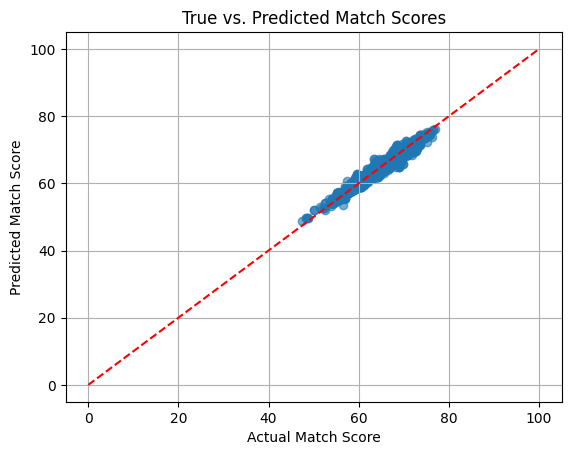

In [43]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Match Score")
plt.ylabel("Predicted Match Score")
plt.title("True vs. Predicted Match Scores")
plt.plot([0, 100], [0, 100], 'r--')
plt.grid(True)
plt.show()

In [44]:
import joblib
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

joblib.dump(regressor, 'models/resume_matcher_new_mode1l.pkl')

['models/resume_matcher_new_model.pkl']